# Random Forests, correlation splitting, and random splitting

Below is a random forest regressor in which the optimal features at any given split are determined by correlation. Like all algorithms that create trees in a greedy fashion, using correlation to determined the split feature is not perfect.  Yet it performs reasonably well in testing.

This regressor also includes the ability to visualize, using ```graphviz```, any of the decision trees in the forest.  It also will plot feature importances.

## Random splitting
Unlike a number of other machine learning algorithms, random forests can handle data sets where some information is missing.  scikit-learn's random forest regressor does not natively handle missing values --- the missing values must be dropped or imputed --- so I wanted to create a random forest regressor that can handle missing values with no extra work.  (scikit-learn's ```Imputer``` can fill in missing values for some types of data, but not all.  For instance, if the missing data is ordinal, the automatically imputed values may not be appropriate for the application.) The regressor below, when passed the argument ```split_method = 'random'```, will seamlessly process a data set that might include missing values.  It does this by selecting features and split values essentially at random.  Generally, trees that are grown in this fashion will have to be deeper than those grown non-randomly.

## Correlation splitting
When the data has no missing values, passing ```split_method = 'corr'``` computes optimal features using correlation and optimal split values to minimize squared error.  

## Cython-optimized split calculator
For correlation splits, the following ```CorrSplitFunction``` class uses Cython to very quickly determine the feature and split value .

In [1]:
%load_ext Cython

In [2]:
%%cython 

import numpy as np
cimport numpy as np
cimport cython

DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

@cython.boundscheck(False) 
@cython.wraparound(False)  

cdef class CorrSplitFunction:
    cdef double[:] arr
    cdef int label_col
    def __call__(self, np.ndarray[DTYPE_t, ndim=2] arr, int label_col):
        # arr should be a 2D numpy array of features+label, with label_col indicated.
        return self.corr_split(arr, label_col)

    cdef DTYPE_t[:] corr_split(self, np.ndarray[DTYPE_t, ndim=2] arr, int label_col):
        cdef Py_ssize_t M = arr.shape[0]
        cdef Py_ssize_t split_row
        cdef Py_ssize_t split_col = arr.shape[1]
        cdef int i
        
        cdef DTYPE_t split_val = float("inf")
        cdef DTYPE_t f, baseline
        cdef DTYPE_t corr = 0
        
        cdef np.ndarray[DTYPE_t, ndim=1] part_sum = np.zeros(M, dtype=DTYPE)
        cdef np.ndarray[DTYPE_t, ndim=1] part_sq_sum = np.zeros(M, dtype=DTYPE)
        cdef np.ndarray[DTYPE_t, ndim=2] corr_matrix, interest_cols
        cdef np.ndarray[DTYPE_t, ndim=1] corr_list, res
        
        # Determine col with highest correlation with label_col
        corr_matrix = np.corrcoef(arr, rowvar=False)
        corr_list = np.abs(corr_matrix[:,label_col])
        for i in range(0, corr_list.shape[0]):
            if i != label_col and corr < corr_list[i] and not np.isnan(corr_list[i]):
                corr = corr_list[i]
                split_col = i
                
        # if split_col is arr.shape[1], corr_matrix didn't yield a split_col.
        if split_col == arr.shape[1]:
            return np.array([np.nan, 0, 0])
        
        # Determine optimal split value
        interest_cols = arr[:, [split_col, label_col]]
        interest_cols = interest_cols[interest_cols[:,0].argsort()]
        part_sum[0] = interest_cols[0,1]
        part_sq_sum[0] = interest_cols[0,1]**2
        for i in range(1,M):
            part_sum[i] = interest_cols[i,1] + part_sum[i-1]
            part_sq_sum[i] = interest_cols[i,1]**2 + part_sq_sum[i-1]
        for i in range(1,M):
            if interest_cols[i,0] == interest_cols[i-1,0]:
                continue
            f = part_sq_sum[i-1] - part_sum[i-1]**2/i + (part_sq_sum[M-1]-part_sq_sum[i-1])-(part_sum[M-1]-part_sum[i-1])**2/(M-i)
            if f < split_val:
                split_val = f
                split_row = i
        baseline = part_sq_sum[M-1] - part_sum[M-1]**2/M
        res = np.array([interest_cols[split_row, 0], split_col, baseline-split_val])
        return res

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import graphviz
from collections import deque


class Node:
    def __init__(self, parent, left, right, key, value, node_id=None, depth=None, gain=None, obs=None):
        self.parent = parent
        self.left = left
        self.right = right
        self.key = key
        self.value = value
        self.node_id = time.time()
        self.depth = None
        self.gain = None
        self.obs = None

        
class BT:
    def __init__(self):
        self.root = None


class DecisionTree(BT):
    '''
    Decision tree.
    Input: 
      dataframe: pandas DataFrame.
      features: list of strings for the names of features in dataframe.
      label: string of label column in dataframe
      agg_method: how leaf nodes aggregate series data; must be 'mean' or 'median.'
      max_box_size: desired number of data points in each leaf node. Loosely enforced.
      max_depth: maximum depth of a tree.  Strictly enfored.
      split_method: either 'corr' or 'random.'
      
    Definitions:
      random_split: randomly choose a feature and a split value. Returns a node
      corr_split: choose a feature based on correlation, and optimal split value. Returns node.
      build_tree: iteratively build binary tree. Returns root node
      series_agg: aggregrate pandas series according to agg_method.
    '''
    
    def __init__(self, data, features, label, agg_method = 'mean', max_box_size=5, max_depth=7, split_method='corr'):
        super().__init__()
        self.features = features
        self.max_box_size = max_box_size
        self.max_depth = max_depth
        self.data = data
        self.label = label
        self.agg_method = agg_method
        self.split_method = split_method
        if self.split_method == 'corr':
            self.corr_split_function = CorrSplitFunction()
        self.root = self.build_tree(self.data, self.features, self.label)
        
        
    def corr_split(self, data, features):
        '''
        Best feature selected by correlation with label.
        Best split value selected in O(n*log(n)) time using MSE.
        '''
        Z = data[features+[self.label]]
        node = Node(None, None, None, None, None)
        label_col = Z.columns.get_loc(self.label)
        arr = Z.values.astype(float)
        res = np.asarray(self.corr_split_function(arr, label_col))
        
        # if res[0] is nan, no correlation split could be calculated. create a leaf.
        if np.isnan(res[0]):
            node.value = Z[self.label].mean()
            node.obs = len(Z[self.label])
            return node
        
        split_val = res[0]
        best_feat = Z.columns[int(res[1])]
        gain = res[2]   
        node.key, node.value, node.gain = best_feat, split_val, gain
        return node     
        
    def random_split(self, data, features):
        '''
        Selects features and split values randomly.
        '''
        split_attempts = 0
        node = Node(None, None, None, None, None)
        while True:
            # random splits do not always work on the first try. 
            split_attempts += 1
            if split_attempts > 5:
                node.value = self.series_agg(data[self.label])
                node.obs = len(data[self.label])
                node.key = None
                break
            else:
                feature = random.choice(features)
                v_samp = data[feature].sample(n=2)
                value = v_samp.mean()
                if not np.isnan(value):
                    split_cond = (data[feature] < value) 
                else:
                    split_cond = (data[feature].isnull()) 
                l_data = data[split_cond]
                r_data = data[~split_cond] 
                if len(l_data) > 0 and len(r_data) > 0:
                    node.key = feature
                    node.value = value
                    break
        return node
    
    def build_tree(self, data, features, label):
        '''
        Iteratively build a decision tree using a deque and BFS.
        '''
        # Each node will be stored with its tree depth
        depth = 0
        
        # data_vec is a condition such that data[data_vec] is the data for each node
        data_vec = (data[features[0]].isnull()) | (~data[features[0]].isnull())
        if self.split_method == 'corr':
            root = self.corr_split(data, features)
        else:
            root = self.random_split(data, features)
        root.depth = depth
        
        # Create and maintain a deque for handling each tree node
        node_queue = deque([(root, data_vec)])  
        while node_queue and depth <= self.max_depth:
            curr_node, data_vec = node_queue.popleft()
            if curr_node.key is None:
                continue
            depth = curr_node.depth + 1
            split_cond = data[curr_node.key] < curr_node.value
            l_data = data[data_vec & split_cond]
            r_data = data[data_vec & ~split_cond]    
            
            # Check if the left side should be a leaf
            if len(l_data) <= self.max_box_size or depth >= self.max_depth:
                l_node = Node(None, None, None, None, None)
                l_node.obs = len(l_data[self.label])
                l_node.value= self.series_agg(l_data[self.label])
                
            # If left is not a leaf, get split and add to queue
            elif len(l_data) > self.max_box_size:
                if self.split_method == 'corr':
                    l_node = self.corr_split(l_data, features)
                else:
                    l_node = self.random_split(l_data, features)
                node_queue.append((l_node, data_vec & split_cond))
    
            # Check if the right side should be a leaf
            if len(r_data) <= self.max_box_size or depth >= self.max_depth:
                r_node = Node(None, None, None, None, None)
                r_node.obs = len(r_data[self.label])
                r_node.value = self.series_agg(r_data[self.label])
                
            # If right is not a leaf, get split and add to queue
            elif len(r_data) > self.max_box_size:
                if self.split_method == 'corr':
                    r_node = self.corr_split(r_data, features)
                else:
                    r_node = self.random_split(r_data, features)
                node_queue.append((r_node, data_vec & ~split_cond))
                
            # update node pointers
            curr_node.left = l_node
            curr_node.right = r_node
            l_node.depth = r_node.depth = depth
            l_node.parent = r_node.parent = curr_node
        return root
            
    def series_agg(self, series):
        '''
        Aggregate a series according to self.agg_method for leaf nodes
        '''
        if self.agg_method == 'median':
            return series.median()
        else:
            return series.mean()
    
        
class RandomForestRegressor:
    '''
    Basic random forest regressor with bagging.
    Can be used on data sets with missing values.
    predict and fit expect a pandas DataFrame for input X.
    y is expected to be a pandas Series.
    '''
    def __init__(self, num_trees=10, max_box_size=3, max_depth=5, agg_method = 'mean', max_features = 0.75, split_method='corr'):
        '''
        num_trees: number of decision trees in the forest
        trees: a list of root nodes of each tree, used internally 
        max_box_size: the desired number of data points for creating a leaf
        max_depth: maximum depth of any tree
        agg_method: how to aggregate the data to create a leaf; choice are 'mean' or 'median.'
        max_features: proportion of features to be sampled.
        split_method: 'random' or 'corr.'
        '''
        self.num_trees = num_trees
        self.trees = None
        self.max_box_size = max_box_size
        self.max_depth = max_depth
        self.agg_method = agg_method
        self.max_features = max_features
        self.split_method = split_method

    def fit(self, X, y):
        '''
        follows sklearn's syntax.
        X is a pandas DataFrame that does not includes the label column.
        y is a pandas Series (labels)
        Tunable parameters: 
          bag_freq: the size of the sample of observations
          num_features: how many features to sample
        '''
        self.trees = []
        bag_freq = len(X)
        features = list(X)
        X = pd.concat([X,y], axis=1)
        num_features = max(int(self.max_features*len(features)), 1)
        for i in range(self.num_trees):
            X_s = X.sample(n=bag_freq, replace=True)
            sample_feat = random.sample(features, num_features)
            Tree = DecisionTree(X_s, sample_feat, y.name, 
                                agg_method=self.agg_method, max_box_size=self.max_box_size, 
                                max_depth=self.max_depth, split_method=self.split_method)
            self.trees.append(Tree.root)
            print("Tree {0} added".format(i))
            
    def predict(self, X):
        '''
        Predict values for DataFrame X.
        '''
        answer = []
        for idx, row in X.iterrows():
            row_answer = []
            for root in self.trees:
                while True:
                    if not root.key:
                        break
                    if row[root.key] < root.value:
                        root = root.left
                    else:
                        root= root.right
                    if not root:
                        break
                if root:
                    row_answer.append(root.value)
            answer.append(np.mean(row_answer))
        return np.array(answer)
    
    def view_tree(self, n):
        '''
        Outputs a graph of the nth decision tree.  
        '''
        from sklearn.tree import export_graphviz
        
        G = graphviz.Digraph()
        root = self.trees[n]
        if root.key is None:
            node_label = str(root.value)
            nodes = deque([])
        else:
            node_label = str(root.key) + '<' + str(root.value)
            nodes = deque([root.left, root.right])
        G.node(str(root.node_id), node_label)           
        while nodes:
            curr = nodes.popleft()
            if curr.key:
                l = str(curr.key) + '<' + str(curr.value)
                G.node(str(curr.node_id), l)        
                nodes.append(curr.left)
                nodes.append(curr.right)
            else:
                G.node(str(curr.node_id), str(int(curr.value)))
            if curr == curr.parent.left:
                G.edge(str(curr.parent.node_id), str(curr.node_id), label='Yes')
            else:
                G.edge(str(curr.parent.node_id), str(curr.node_id), label='No')
        G.render(view=True)
        
    def feature_importance(self):
        '''
        Plot the relative feature importances.
        '''
        if self.split_method == 'random':
            print("Feature importance is not available for random splits")
            return
        M = len(self.trees)
        feature_dict = {}
        def inorder(root):
            if root.key:
                inorder(root.left)
                if root.key in feature_dict:
                    feature_dict[root.key] += root.gain
                else:
                    feature_dict[root.key] = root.gain
                inorder(root.right)
        for tree in self.trees:
            inorder(tree)
            
        # scale all features to max 100.
        scale = 100/np.sqrt(max(feature_dict.values())/M)
        for feat in feature_dict:
            feature_dict[feat] = int(np.sqrt(feature_dict[feat]/ M)*scale)
        y = sorted(feature_dict.items(), key = lambda x:x[1], reverse=False)
        names = [n[0] for n in y]
        vals = [n[1] for n in y]
        ax = plt.barh(names, vals, tick_label=names)
        plt.show()
                        

In [4]:
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set()
sns.set_palette("Set2")
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10, 8

## Features and testing
We'll use the [Ames, Iowa house dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) to show the features of this regressor and test its performance. 

In [5]:
train = pd.read_csv('/Users/craigkleski/PythonPractice/MachineLearning/house_prices/train.csv')
X = train[['HouseStyle','BsmtQual','ExterQual','Neighborhood','OverallQual','LotFrontage','LotArea','YrSold','OverallCond','YearBuilt','GrLivArea','BedroomAbvGr','SalePrice']]
X = X.dropna(axis=0)
X = pd.get_dummies(X, columns=['HouseStyle','BsmtQual','ExterQual','Neighborhood'])
y = X['SalePrice']
X = X.drop(columns=['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
pred = RF.predict(X_val)

/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Tree 0 added
Tree 1 added
Tree 2 added
Tree 3 added
Tree 4 added
Tree 5 added
Tree 6 added
Tree 7 added
Tree 8 added
Tree 9 added


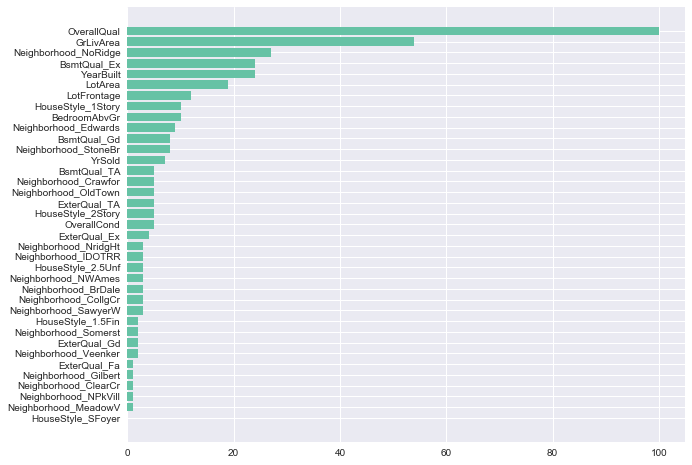

In [6]:
RF.feature_importance()

The following will render decision tree \#2 in your default PDF viewer.  It would be nice if Jupyter could display this inline.

In [7]:
RF.view_tree(2)

Now we'll see how the regressor performs, in its default configuration, compared to sklearn.

In [8]:
from sklearn import ensemble
SRF = ensemble.RandomForestRegressor()
SRF.fit(X_train, y_train)
spred = SRF.predict(X_val)
me = np.linalg.norm(y_val-pred)
skl = np.linalg.norm(y_val-spred)
print(me, skl)

484165.0317705774 469931.3007404487


Neither model was tuned for this example.  Out of the box, both regressors have similar performance on the data set.

Now we'll test the performance on the _full_ data set, not dropping rows with missing data. We set the split method to ```'random'``` and increase the default depth.

In [9]:
X = train[['HouseStyle','BsmtQual','ExterQual','Neighborhood','OverallQual','LotFrontage','LotArea','YrSold','OverallCond','YearBuilt','GrLivArea','BedroomAbvGr','SalePrice']]
#X = X.dropna(axis=0)
X = pd.get_dummies(X, columns=['HouseStyle','BsmtQual','ExterQual','Neighborhood'])
y = X['SalePrice']
X = X.drop(columns=['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
RF = RandomForestRegressor(num_trees=10, split_method='random', max_depth=10, max_features = 1, agg_method='median')
RF.fit(X_train, y_train)
pred = RF.predict(X_val)

Tree 0 added
Tree 1 added
Tree 2 added
Tree 3 added
Tree 4 added
Tree 5 added
Tree 6 added
Tree 7 added
Tree 8 added
Tree 9 added


In [10]:
np.linalg.norm(pred-y_val)

837076.869156398